# CCEM/CALM Image Tutorial #4

Introduction to mage series registration

In [ ]:
# To run only if using jupyter notebook through binder
# Install the required packages in Jupyter kernel (internet connection required)

import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install imageio
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install pystackreg

In [1]:
# Libraries from tutorial #1
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

# libraries for tutorial #3
import matplotlib.animation as animation 

# New libraries for tutorial #4
import skimage.registration as registration
from pystackreg import StackReg
from skimage.transform import AffineTransform, warp

In [2]:
%matplotlib notebook

 Add documentation

## Load data series

In [3]:
data = io.volread('STEM_HAADF_series.tif')

In [4]:
print(data.meta)

Dict([('is_fluoview', False), ('is_nih', False), ('is_micromanager', False), ('is_ome', False), ('is_lsm', False), ('is_reduced', <FILETYPE.UNDEFINED: 0>), ('is_shaped', None), ('is_stk', False), ('is_tiled', False), ('is_mdgel', False), ('compression', <COMPRESSION.NONE: 1>), ('predictor', 1), ('is_mediacy', False), ('description', 'ImageJ=1.11a\nimages=10\nframes=10\nhyperstack=true\nmode=grayscale\nloop=false\nunit=nm\nnion.1={"spatial_calibrations": [{"offset": 0.0, "scale": 1.0, "units": ""}, {"offset": -12.5, "scale": 0.0244140625, "units": "nm"}, {"offset": -12.5, "scale": 0.0244140625, "units": "nm"}], "intensity_calibration": {"offset": 0.0, "scale": 1.0, "units": ""}, "is_sequence": true, "collection_dimension_count": 0, "datum_dimension_count": 2, "properties": {"hardware_source_id": "superscan", "hardware_source_name": "SuperScan", "exposure": 2.0097706666666704, "frame_index": 0, "channel_id": "a", "channel_name": "HADF", "pixel_time_us": 1.91666666666667, "line_time_us": 

In [5]:
print(type(data))
print(data.shape)

<class 'imageio.core.util.Array'>
(10, 1024, 1024)


<IPython.core.display.Javascript object>


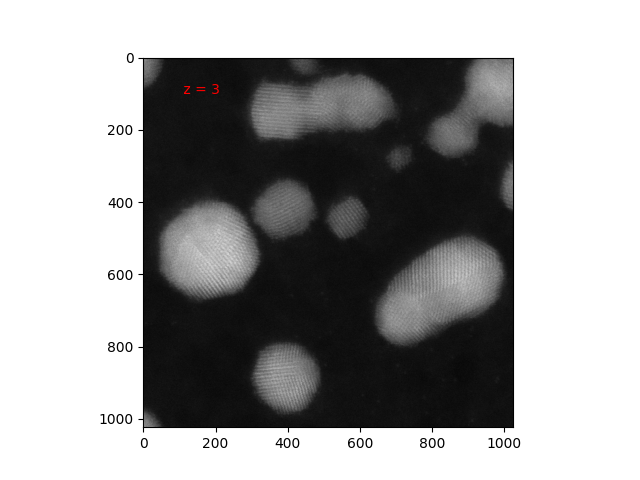

In [6]:
# Visualization of the raw image series (animation)

fig_raw, ax_raw = plt.subplots()

frames_raw = []

for i, image in enumerate(data):
    frames_raw.append([ax_raw.imshow(image, cmap='gray'), ax_raw.annotate(' z = ' + str(i), (100, 100), color='red')])
    
ani_raw = animation.ArtistAnimation(fig_raw, frames_raw, interval=200, blit=True, repeat_delay=200)

plt.show()

## Simple shit registration

In [7]:
# Measure the shift between 2 images
params = registration.phase_cross_correlation(data[0], data[9], upsample_factor=10)

In [8]:
print(params)

(array([0.3, 0. ], dtype=float32), 0.9999999971591231, -0.002897186)


In [9]:
# Measure and correct the shift for the whole image series using the first image as the reference
data_series_shifted = np.empty((10, 1024, 1024))

for i, image in enumerate(data):
    params = registration.phase_cross_correlation(data[0], image, upsample_factor=10)
    transformation = AffineTransform(translation=params[0])
    image_shifted = warp(image, transformation)
    data_series_shifted[i] = image_shifted

<IPython.core.display.Javascript object>


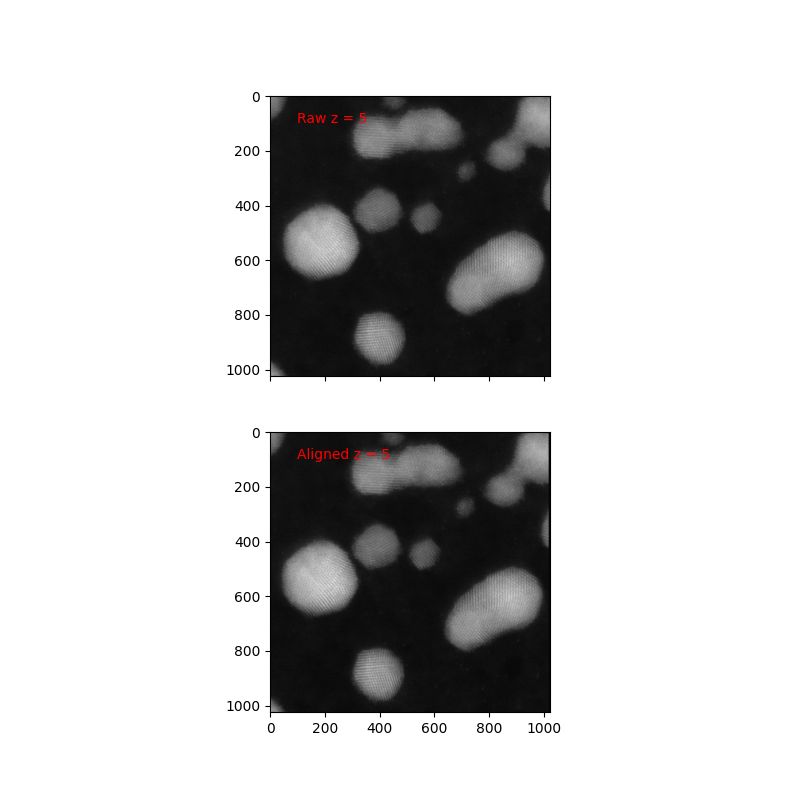

In [10]:
# Compare the raw and aligned data series

fig_comp, ax_comp = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

frames_comp = []

for i, image in enumerate(data):
    frames_comp.append([ax_comp[0].imshow(image, cmap='gray'), ax_comp[0].annotate('Raw z = ' + str(i), (100, 100), color='red'),
                        ax_comp[1].imshow(data_series_shifted[i], cmap='gray'), ax_comp[1].annotate('Aligned z = ' + str(i), (100, 100), color='red')
                       ])
    
ani_comp = animation.ArtistAnimation(fig_comp, frames_comp, interval=200, blit=True, repeat_delay=200)

plt.show()

<IPython.core.display.Javascript object>


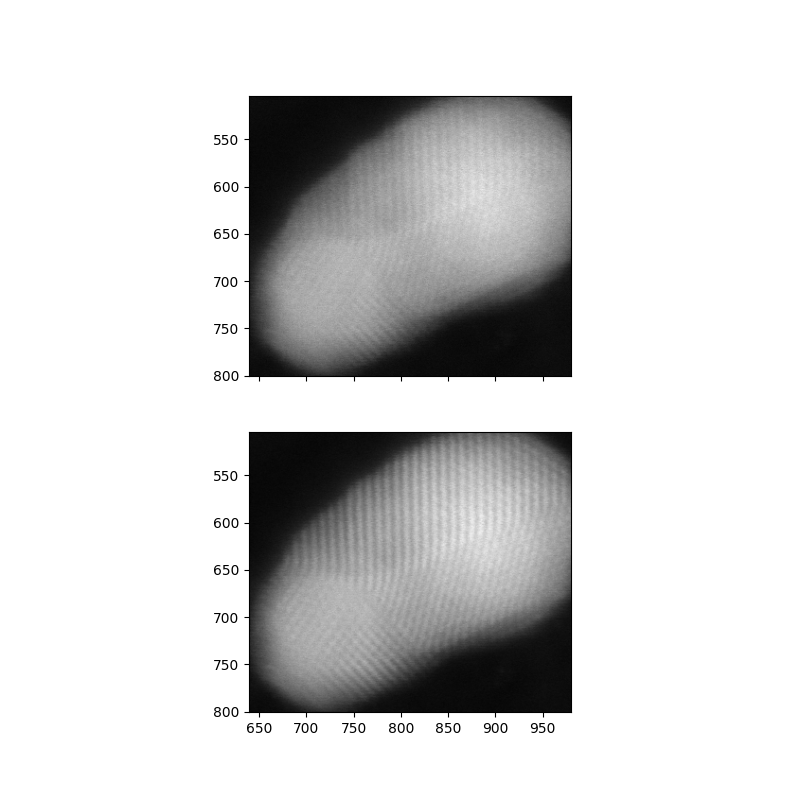

In [11]:
# Compare the average of the raw and the aligned data series

fig_comp_av, ax_comp_av = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

ax_comp_av[0].imshow(np.average(data, axis=0), cmap='gray')
ax_comp_av[1].imshow(np.average(data_series_shifted, axis=0), cmap='gray')

plt.show()

## Dedicated library to register image series

In [12]:
# Initialize transformation for image series registration
sr_T = StackReg(StackReg.TRANSLATION)
sr_RB = StackReg(StackReg.RIGID_BODY)

In [13]:
# Examples of translation and rigib body registration
align_T = sr_T.register_stack(data, reference='first', verbose=True)
align_RB = sr_RB.register_stack(data, reference='first', verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]


In [14]:
# Matrix transformation for the translation case for each image of the series
print(align_T)

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 1.          0.         -0.45784973]
  [ 0.          1.         -0.03326423]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          1.37830432]
  [ 0.          1.         -0.57007639]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          2.37229627]
  [ 0.          1.         -0.66485428]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          5.1178428 ]
  [ 0.          1.         -2.28196352]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          6.78711252]
  [ 0.          1.         -2.18782088]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          7.40862539]
  [ 0.          1.         -2.53234184]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          6.85078879]
  [ 0.          1.         -0.66962284]
  [ 0.          0.          1.        ]]

 [[ 1.          0.      

In [15]:
# Matrix transformation for the rigid body case for each image of the series
print(align_RB)

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99998466e-01  1.75148044e-03 -1.28950311e+00]
  [-1.75148044e-03  9.99998466e-01  8.41467794e-01]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99999985e-01 -1.70706521e-04  1.42714725e+00]
  [ 1.70706521e-04  9.99999985e-01 -6.25032675e-01]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99999997e-01  7.98147152e-05  2.28722199e+00]
  [-7.98147152e-05  9.99999997e-01 -5.95805390e-01]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -2.27525666e-05  5.09286785e+00]
  [ 2.27525666e-05  1.00000000e+00 -2.28065352e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99995916e-01 -2.85788357e-03  7.63683718e+00]
  [ 2.85788357e-03  9.99995916e-01 -3.66709315e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00  1.63529879e-05  7.38476635e+00]


In [16]:
# Apply the translation transformation on the raw series
data_series_registered_T = sr_T.transform_stack(data)

In [17]:
# Apply the rigib body transformation on the raw series
data_series_registered_RB = sr_RB.transform_stack(data)

<IPython.core.display.Javascript object>


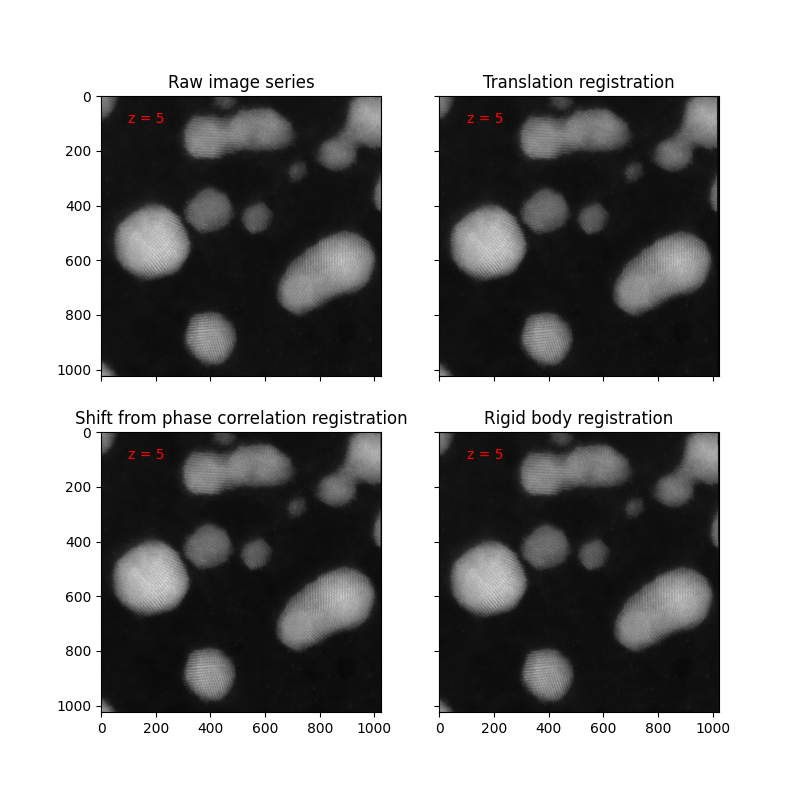

In [21]:
# Comparison between the raw and all the registered image series
fig_comp_final, ax_comp_final = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

frames_comp_final = []

for i, image in enumerate(data):
    frames_comp_final.append([ax_comp_final[0, 0].imshow(image, cmap='gray'), ax_comp_final[0, 0].annotate('z = ' + str(i), (100, 100), color='red'),
                              ax_comp_final[1, 0].imshow(data_series_shifted[i], cmap='gray'), ax_comp_final[1, 0].annotate('z = ' + str(i), (100, 100), color='red'),
                              ax_comp_final[0, 1].imshow(data_series_registered_T[i], cmap='gray'), ax_comp_final[0, 1].annotate('z = ' + str(i), (100, 100), color='red'),
                              ax_comp_final[1, 1].imshow(data_series_registered_RB[i], cmap='gray'), ax_comp_final[1, 1].annotate('z = ' + str(i), (100, 100), color='red')
                             ])

ax_comp_final[0, 0].set_title('Raw image series')
ax_comp_final[1, 0].set_title('Shift from phase correlation registration')
ax_comp_final[0, 1].set_title('Translation registration')
ax_comp_final[1, 1].set_title('Rigid body registration')
    
ani_comp_final = animation.ArtistAnimation(fig_comp_final, frames_comp_final, interval=200, blit=True, repeat_delay=200)

plt.show()

<IPython.core.display.Javascript object>


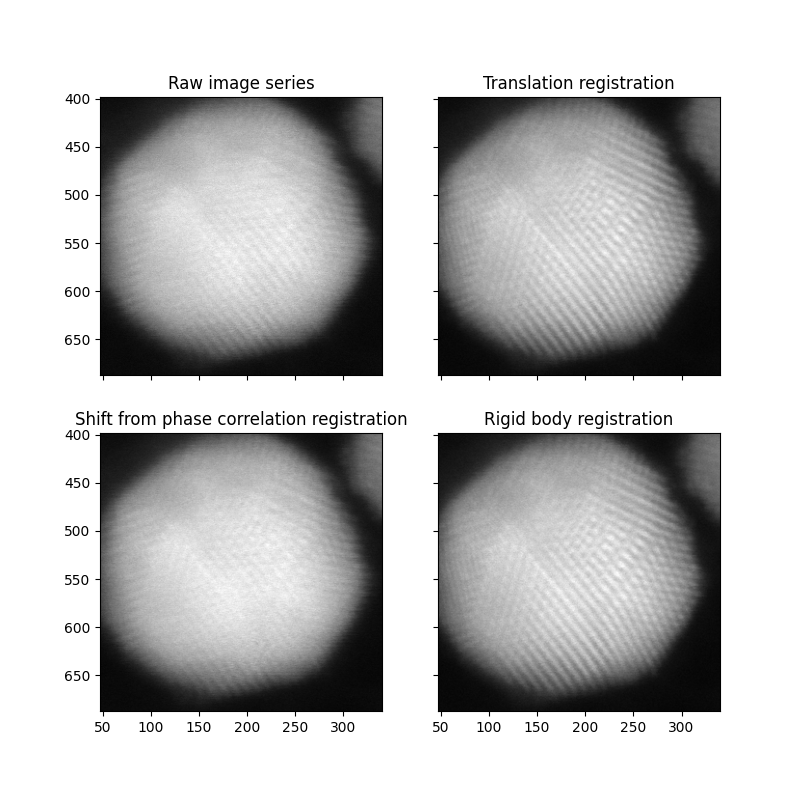

In [22]:
# Compare the average of the raw and all the aligned data series

fig_comp_av_final, ax_comp_av_final = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

ax_comp_av_final[0, 0].imshow(np.average(data, axis=0), cmap='gray')
ax_comp_av_final[1, 0].imshow(np.average(data_series_shifted, axis=0), cmap='gray')
ax_comp_av_final[0, 1].imshow(np.average(data_series_registered_T, axis=0), cmap='gray')
ax_comp_av_final[1, 1].imshow(np.average(data_series_registered_RB, axis=0), cmap='gray')

ax_comp_av_final[0, 0].set_title('Raw image series')
ax_comp_av_final[1, 0].set_title('Shift from phase correlation registration')
ax_comp_av_final[0, 1].set_title('Translation registration')
ax_comp_av_final[1, 1].set_title('Rigid body registration')

plt.show()